In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(8, 8))

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [3]:
# Import dataset
df = pd.read_csv('Datasets/Auditions.db.comp.csv', encoding='latin-1', low_memory=False)
df = df[df["year"] == 2020]

# Missing percentage
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})

missing_value_df

,column_name,percent_missing
Name,Name,0.000000
n_poste,n_poste,0.000000
Level,Level,50.691244
Section,Section,63.594470
Role,Role,84.792627
status,status,0.000000
year,year,0.000000
institutions,institutions,38.095238
ID,ID,18.740399
X,X,100.000000


Data pre-processing

In [4]:
df.dropna(subset=["ID"], inplace = True)
df["Name"] = df["Name"].apply(lambda x: x.strip())

In [5]:
df_int = df[df["status"] == "interne"].dropna(subset=["institutions"])
df_int["institutions"] = df_int["institutions"].apply(lambda x: x.strip())
df_int["institutions"].replace('CY CERGY PARIS UNIVERSITE', 'CY Cergy Paris Université', inplace = True)
df_int.groupby("ID")["Name", "institutions"].agg(pd.Series.mode).to_csv("datasets/nodes_int.csv")
df_int.shape

(247, 12)

In [6]:
df_ext = df[df["status"] == "externe"]
df_ext.groupby("ID")["Name"].agg(pd.Series.mode).to_csv("datasets/nodes_ext.csv")
df_ext.shape

(282, 12)

In [7]:
import networkx as nx
from itertools import combinations, chain
from collections import Counter

def Graph(df):
    L = df.groupby("n_poste")["ID"].agg(list).values.tolist()
    # Get all edges from each Poste 
    L2_nested = [list(combinations(l, 2)) for l in L]
    # Flatten the nested list to a list
    L2 = chain.from_iterable(L2_nested)
    # Build a counter -> amount of entries = edge weight
    c = Counter(tuple(sorted(t)) for t in L2).items()
    # Flatten the dictionary to tuples (source, dest, weight)
    weighted_edges = [(*edge, weight) for edge, weight in c]
    # Create networkx graph and add weighted edges
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    # Add attributes to node
    #name = df.groupby("ID")["Name"].agg(lambda x:x.value_counts().index[0]).to_dict()
    #level = df.groupby("ID")["Level"].agg(lambda x:x.value_counts().index[0]).to_dict()
    #nx.set_node_attributes(G, name, "Name")
    #nx.set_node_attributes(G, level, "Level")
    #G = nx.relabel_nodes(G, name, copy=False)

    return G

import community as community_louvain
import matplotlib.cm as cm

In [8]:
def community_detection(G):
    #first compute the best partition
    partition = community_louvain.best_partition(G)

    # draw the graph
    pos = nx.spring_layout(G)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=50,
                            cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

In [9]:
def most_important_node_in_partition(graph, partition_dict):
    max_d = {}
    deg = nx.degree_centrality(graph)
    for group in partition_dict:
        temp = 0
        for character in partition_dict[group]:
            if deg[character] > temp:
                max_d[group] = character
                temp = deg[character]
    return max_d

In [10]:
G = Graph(df_int)
nx.write_weighted_edgelist(G, "datasets/graph_int.csv", delimiter=',')
G.number_of_nodes()

206

In [11]:
G = Graph(df_ext)
nx.write_weighted_edgelist(G, "datasets/graph_ext.csv", delimiter=',')
G.number_of_nodes()

220

Betweeness Centrality

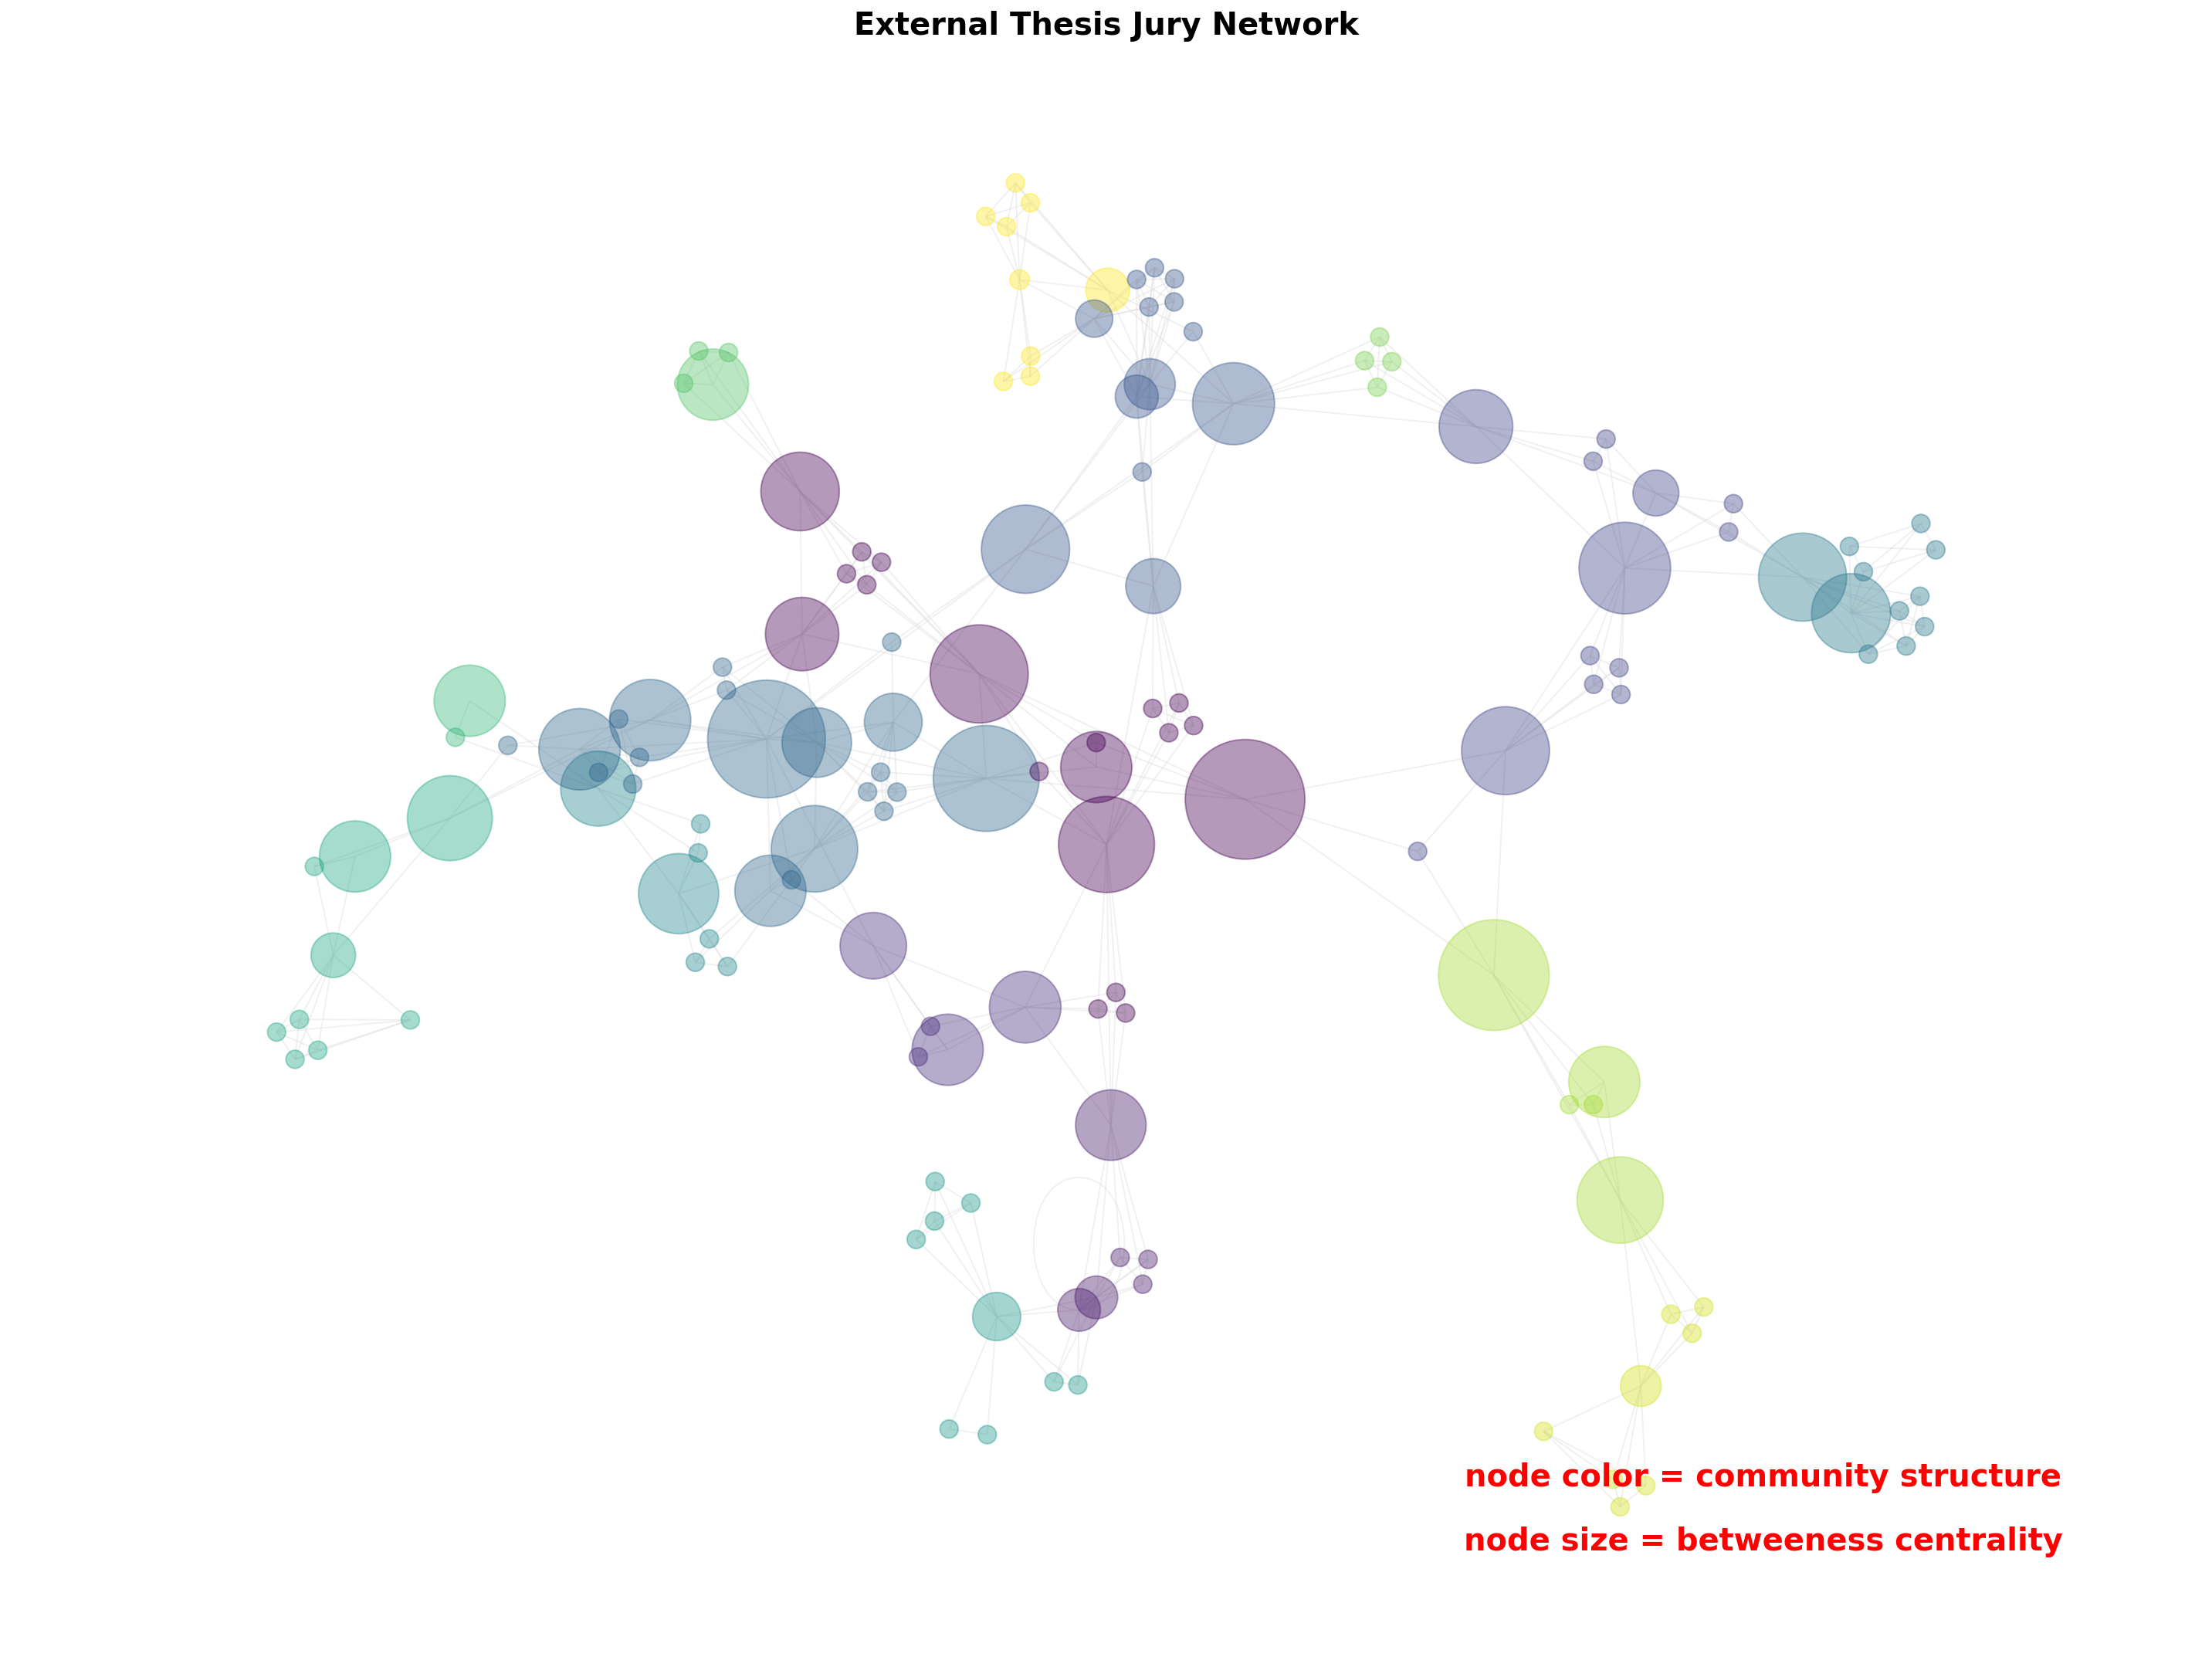

In [12]:
# remove low-degree nodes
low_degree = [n for n, d in G.degree() if d < 2]
G.remove_nodes_from(low_degree)

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Thesis' External Jury Network", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "node color = community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size = betweeness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

### 

# Sankey diagram and Chord plot

In [13]:
# Sankey diagram
label = ["B2", "ERASMUS", "B3", "ING1", "B4", "ERASMUS", "EW", "ING2"]
source = [1, 0, 0 , 0, 2, 2 , 3]
target = [2, 6, 2 , 3, 5, 4 , 7]
value  = [4, 1, 13, 5, 4, 13, 5]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
    )
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.show()

KeyError: 'Level'

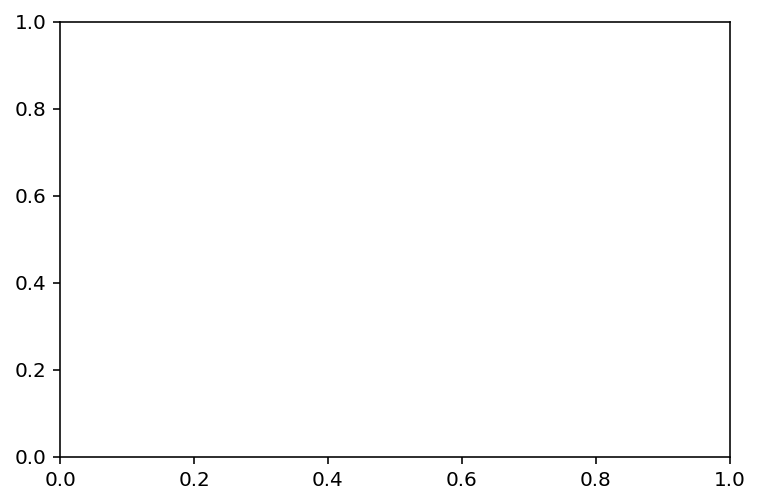

In [14]:
import nxviz as nv 
from nxviz import annotate

nv.circos(G, group_by="Level", node_color_by="Level")
annotate.circos_group(G, group_by="Level")

# Market basket analysis

In [ ]:
df = pd.read_csv("datasets/tel_samp_rec.csv", encoding='latin-1', low_memory=False)

In [ ]:
df_disc1 = df.loc[:, ['disc1.rec.lev1']].reset_index().rename(columns={"disc1.rec.lev1": "disc"})
df_disc1.loc[:, 'quantity'] = 1
df_disc2 = df.loc[:, ['disc2.rec.lev1']].reset_index().rename(columns={"disc2.rec.lev1": "disc"})
df_disc2.loc[:, 'quantity'] = 1
df_disc3 = df.loc[:, ['disc3.rec.lev1']].reset_index().rename(columns={"disc3.rec.lev1": "disc"})
df_disc3.loc[:, 'quantity'] = 1
df = pd.concat([df_disc1, df_disc2, df_disc3])
#df.drop().head()

In [ ]:
transactions = df.drop(columns=['quantity']).rename(columns={"index":"trans_id", "disc":"item_id"})
transactions = transactions.dropna().drop_duplicates()
transactions = transactions[['item_id', 'trans_id']]
transactions.to_csv('datasets/transactions.csv')

In [ ]:
transactions

In [ ]:
basket = df.groupby(['index', 'disc'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('index')
basket.head()

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units) # Encode the basket
basket_sets = basket_sets[basket_sets.sum(axis=1) > 1] # Only keep transaction that has more than 1 item

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Compute the frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support = 0.03, 
                            use_colnames = True)

# Compute rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [ ]:
import seaborn as sns

# Convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform antecedent, consequent, and support columns into matrix
support_table = rules.pivot(index='consequents', columns='antecedents', values='support')

plt.figure(figsize=(10,6))
sns.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
# Add title and axis names
plt.title('Support heatmap')
plt.show()

In [ ]:
# Transform antecedent, consequent, and support columns into matrix
lift_table = rules.pivot(index='consequents', columns='antecedents', values='lift')

plt.figure(figsize=(10,6))
sns.heatmap(lift_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.title('Lift heatmap')
plt.show()

In [ ]:
# Function to convert rules to coordinates.
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

In [ ]:
from pandas.plotting import parallel_coordinates

# Compute the frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support = 0.03, 
                            use_colnames = True)

# Compute rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()